##Downloading dataset

In [ ]:
!pip install rarfile
import rarfile

rar_file = rarfile.RarFile('/content/drive/MyDrive/CTpred-Sunitinib-panNET.rar')
rar_file.extractall('/content')
rar_file.close()

##Getting names of all the .dcm files from different folders

In [ ]:
!pip install pydicom

import numpy as np
import pydicom
from PIL import Image
import os

def get_names(path):
  names = []
  for root, dirnames, filenames in os.walk(path):
    for filename in filenames:
      _ , ext = os.path.splitext(filename)
      if ext in ['.dcm']:
        names.append(filename)
  return (names)

names = (get_names('/content/CTpred-Sunitinib-panNET'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.7 MB/s eta 0:00:00


##Function to convert .dcm files to .png

In [ ]:
def convert_dcm_jpg(im):



  im = im.pixel_array.astype(float)

  final_image = np.uint8(im)
  final_image = Image.fromarray(final_image)
  return final_image

"""from pathlib import Path
input_dir  = Path.cwd()
files = (list(input_dir.rglob("*.dcm")))"""



'from pathlib import Path\ninput_dir  = Path.cwd()\nfiles = (list(input_dir.rglob("*.dcm")))'

##Reading all the .dcm files

In [ ]:
import os
from pathlib import Path
import pydicom

dir_path = r"/content/CTpred-Sunitinib-panNET"

dicom_set = []
for root, _, filenames in os.walk(dir_path):
    for filename in filenames:
        dcm_path = Path(root, filename)
        if dcm_path.suffix == ".dcm":
            try:
                dicom = pydicom.dcmread(dcm_path, force=True)
            except IOError as e:
                print(f"Can't import {dcm_path.stem}")
            else:
                dicom_set.append(dicom)

#Converting .dcm to .png

In [ ]:

for index , im in enumerate(dicom_set):

  image = convert_dcm_jpg(im)
  image.save(names[index]+'.png')

##Moving all the images to a new folder

In [ ]:
 import os
import shutil
sourcepath='/content/'
sourcefiles = os.listdir(sourcepath)
destinationpath = '/content/New'
for file in sourcefiles:
    if file.endswith('.png'):
        shutil.move(os.path.join(sourcepath,file), os.path.join(destinationpath,file))





##Function to get the count of images

In [ ]:
import os

# folder path
dir_path = r'/content/New'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 2087


In [ ]:
!zip -r New.zip New/

  adding: New/ (stored 0%)
  adding: New/1-0011.dcm.png (deflated 0%)
  adding: New/1-454.dcm.png (deflated 0%)
  adding: New/1-338.dcm.png (deflated 0%)
  adding: New/1-0620.dcm.png (deflated 0%)
  adding: New/1-1026.dcm.png (deflated 0%)
  adding: New/1-70.dcm.png (deflated 0%)
  adding: New/1-0635.dcm.png (deflated 0%)
  adding: New/1-1031.dcm.png (deflated 0%)
  adding: New/1-0368.dcm.png (deflated 0%)
  adding: New/1-0719.dcm.png (deflated 0%)
  adding: New/1-0898.dcm.png (deflated 0%)
  adding: New/1-1243.dcm.png (deflated 0%)
  adding: New/1-0319.dcm.png (deflated 0%)
  adding: New/1-0769.dcm.png (deflated 0%)
  adding: New/1-393.dcm.png (deflated 0%)
  adding: New/1-077.dcm.png (deflated 0%)
  adding: New/1-266.dcm.png (deflated 0%)
  adding: New/1-0523.dcm.png (deflated 0%)
  adding: New/1-651.dcm.png (deflated 0%)
  adding: New/1-0744.dcm.png (deflated 0%)
  adding: New/1-684.dcm.png (deflated 0%)
  adding: New/1-090.dcm.png (deflated 0%)
  adding: New/1-0530.dcm.png (deflate

##Downloading the new dataset


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/New.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

##Importing the necessary dependencies

In [ ]:
import cv2
import glob
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

##Function to read and preprocess images

In [ ]:
train_path = '/content/New'

IMG_SIZE = 128

def get_data_from_folder(path):
  train_batches = []
  files = glob.glob(path+"/*") # get files in each folder(class)
  for f in files:
        img = cv2.imread(f) #read the image
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE)) #resize the image
        train_batches.append(np.array(img)/255) #Append images and corresponding labels to data
  np.random.shuffle(train_batches)
  return train_batches

training_data = get_data_from_folder(train_path)

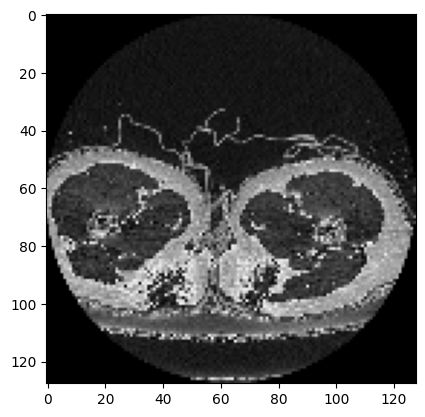

In [ ]:
plt.imshow(training_data[45])


##Function to add noise to image

In [ ]:
def add_noise(image):
  row,col,ch=image.shape
  mean=0
  sigma=5
  gauss=np.random.normal(mean,sigma,(row,col,ch))
  gauss=gauss.reshape(row,col,ch)
  noisy=image+gauss*0.08
  return noisy

noised_df=[]
for img in training_data:
  noisy=add_noise(img)
  noised_df.append(noisy)

noised_df=np.array(noised_df)

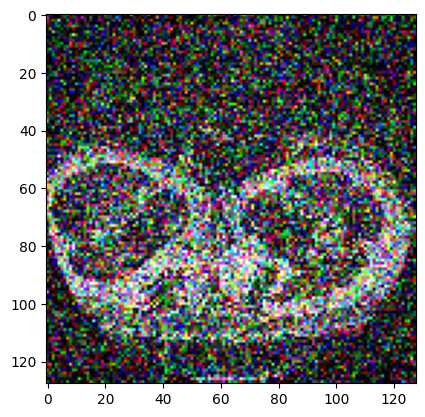

In [ ]:
plt.imshow(noised_df[45])


In [ ]:
def plot_img(dataset):
  f,ax=plt.subplots(1,5)
  f.set_size_inches(40,20)
  for i in range(5,10):
    ax[i-5].imshow(dataset[i].reshape(256,256,3), cmap='gray')
  plt.show()



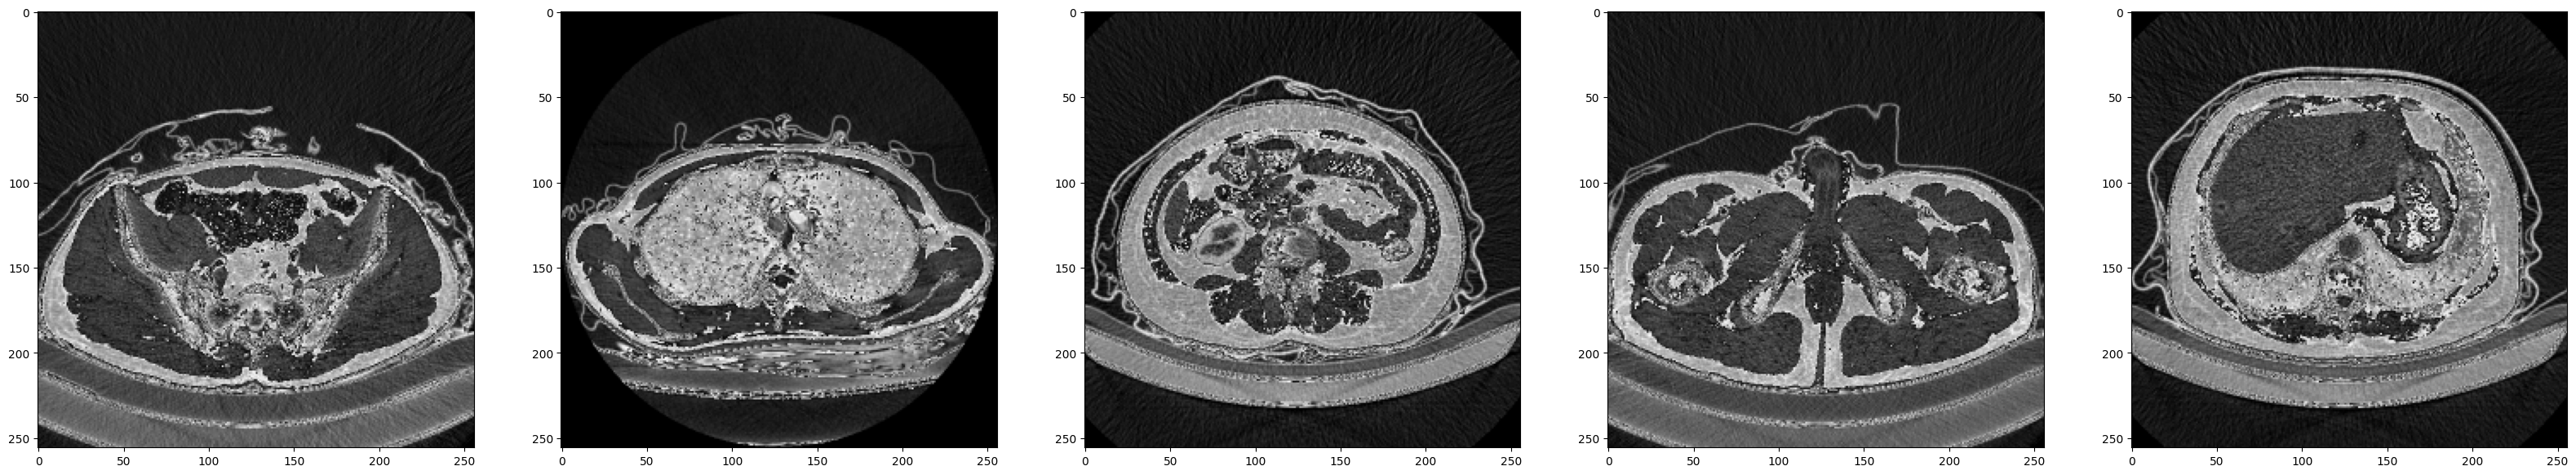

In [ ]:
plot_img(training_data)


##Splitting data

In [ ]:

training_data = np.array(training_data)

X_train = noised_df[0:2000]
Y_train = training_data[0:2000]

X_test = noised_df[2000:]
Y_test = training_data[2000:]




##Model buiding and fitting

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Activation, Flatten, Reshape


from keras.models import Model, Sequential

from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam, Adadelta, Adagrad

In [ ]:
from tensorflow.python.ops.math_ops import xdivy
def autoencoder():

#Encoder
  input_image = Input(shape=(128,128,3))


  x = Conv2D(256, (3, 3),  activation='relu', padding='same')(input_image)
  x = BatchNormalization()(x)

  x = Conv2D(256, (3, 3),  activation='relu', padding='same')(x)
  x = BatchNormalization()(x)


  x = Conv2D(128, (3, 3), strides = 2, activation='relu', padding='same')(x)
  x = BatchNormalization()(x)

  x = Conv2D(128, (3, 3), strides = 2, activation='relu', padding='same')(x)
  x = BatchNormalization()(x)


  x = Conv2D(64, (3, 3), strides = 2, activation='relu', padding='same')(x)
  x = BatchNormalization()(x)


  x = Conv2D(64, (3, 3), strides = 2, activation='relu', padding='same')(x)
  x = BatchNormalization()(x)

  x = Conv2D(32, (3, 3),  activation='relu', padding='same')(x)#32
  x = BatchNormalization()(x)

  x = Flatten()(x)

  x = Dense(8192, activation = 'relu')(x)

#Code

  x = Dense(4096, activation = 'relu')(x)

#Decoder

  x = Dense(8192, activation = 'relu')(x)
  x=Reshape((16,16,32))(x)

  x = Conv2D(32, (3,3), padding = "same", activation = 'relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(64, (3,3),strides = 2, padding = "same", activation = 'relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(64, (3,3), padding = "same", activation = 'relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(128, (3,3), padding = "same", activation = 'relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(128, (3,3), padding = "same", strides = 2, activation = 'relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(256, (3,3), padding = "same", activation = 'relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(3, (3,3),strides = 2, padding = "same", activation = 'relu')(x)
  x = BatchNormalization()(x)

  autoencoder = Model(inputs=input_image, outputs=x)

  Adam_opt =Adam(lr=0.001)
  autoencoder.compile(optimizer=Adam_opt, loss='binary_crossentropy')
  return autoencoder













In [ ]:
from keras.optimizers import Adam
autoencoder = autoencoder()
autoencoder.summary()



Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_641 (Conv2D)         (None, 128, 128, 256)     7168      
                                                                 
 batch_normalization_715 (Ba  (None, 128, 128, 256)    1024      
 tchNormalization)                                               
                                                                 
 conv2d_642 (Conv2D)         (None, 128, 128, 256)     590080    
                                                                 
 batch_normalization_716 (Ba  (None, 128, 128, 256)    1024      
 tchNormalization)                                               
                                                                 
 conv2d_643 (Conv2D)         (None, 64, 64, 128)       295

In [ ]:
history = autoencoder.fit(X_train, Y_train, epochs=8, batch_size=1, validation_data=(X_test, Y_test))
history.save_weights('my_model_weights.h5')
history.save('my_model_history.h5')


Epoch 1/8
2000/2000 [==============================] - 22s 10ms/step - loss: 0.9577 - val_loss: 0.5527
Epoch 2/8
2000/2000 [==============================] - 19s 10ms/step - loss: 0.5020 - val_loss: 0.5288
Epoch 3/8
2000/2000 [==============================] - 19s 10ms/step - loss: 0.5003 - val_loss: 0.5149
Epoch 4/8
2000/2000 [==============================] - 19s 10ms/step - loss: 0.4877 - val_loss: 0.4817
Epoch 5/8
2000/2000 [==============================] - 20s 10ms/step - loss: 0.4745 - val_loss: 0.4686
Epoch 6/8
2000/2000 [==============================] - 19s 10ms/step - loss: 0.4721 - val_loss: 0.4613
Epoch 7/8
2000/2000 [==============================] - 19s 10ms/step - loss: 0.4680 - val_loss: 0.4587
Epoch 8/8
2000/2000 [==============================] - 19s 10ms/step - loss: 0.4743 - val_loss: 0.4650


1/1 [==============================] - 0s 326ms/step


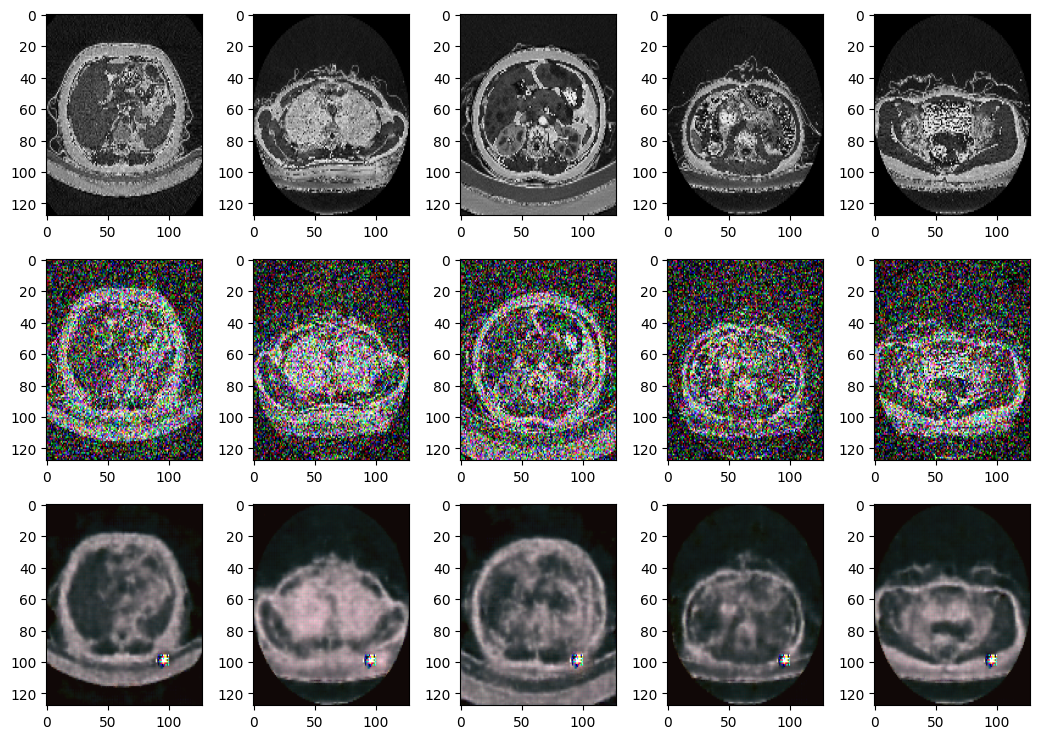

In [ ]:
pred= autoencoder.predict(X_train[0:5])
def plot_predictions(y_true, y_pred):
    f, ax = plt.subplots(3, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(Y_train[i], (128,128,3)), aspect='auto')
        ax[1][i].imshow(np.reshape(y_true[i], (128,128,3)), aspect='auto')
        ax[2][i].imshow(np.reshape(y_pred[i], (128,128,3)), aspect='auto')

    plt.tight_layout()
plot_predictions(X_train[:5], pred[:5])


##Vizualizing loss

<ipython-input-240-ee8fd30207ac>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_train, 'g', label='Training loss', color = 'orange')
<ipython-input-240-ee8fd30207ac>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_val, 'b', label='validation loss', color = 'blue')


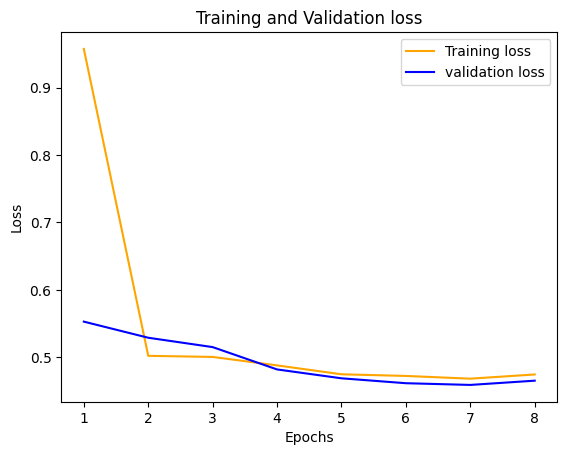

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,9)
plt.plot(epochs, loss_train, 'g', label='Training loss', color = 'orange')
plt.plot(epochs, loss_val, 'b', label='validation loss', color = 'blue')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()